In [1]:
suppressPackageStartupMessages({
    library(monocle)

    library(RColorBrewer)
    library(dplyr)
    library(ggplot2)
    library(glasso)
    library(glmnet)
    library(igraph)
    library(pheatmap)
    library(qgraph)
    library(scales)
    library(reshape2)
})

Warning message:
“replacing previous import by ‘splines::splineDesign’ when loading ‘VGAM’”Warning message:
“replacing previous import by ‘grid::arrow’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘grid::unit’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::clusters’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘ggplot2::Position’ when loading ‘monocle’”

This analysis was made using Monocle version 2.3.5. The source code for Monocle 2.3.5 is available as a supplementary file to Cao et al. 2017 on the Science website. We are working on updating the analysis to the latest version of Monocle.

In [2]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.8 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] reshape2_1.4.2      scales_0.4.1        qgraph_1.4.3       
 [4] pheatmap_1.0.8      igraph_1.0.1        glmnet_2.0-10      
 [7] foreach_1.4.3       glasso_1.8          dplyr_0.7.1        
[10] RColorBrewer_1.1-2  monocle_2.3.5       DDRTree_0.1.5      
[13] irlba_2.2.1         VGAM_1.0-3          ggplot2_2.2.1      
[16] Biobase_2.30.0      BiocGeneric

In [3]:
# at certain "checkpoints" in this notebook, we save our progress to this RData file
# run this cell to load your progress if you have already reached through one or more checkpoints in the notebook

# IF YOU RUN THIS CELL DO NOT RUN THE CELL BELOW

load("RData/L2.ChIP-seq.analysis.RData")

In [ ]:
load("RData/L2.data.summaries.no-cruft.RData")

In [4]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/C.elegans.modENCODE.modERN.ChIP-seq.peak.to.gene.assignments.tsv",
    destfile = "RData/C.elegans.modENCODE.modERN.ChIP-seq.peak.to.gene.assignments.tsv")

In [5]:
peaks = read.table("RData/C.elegans.modENCODE.modERN.ChIP-seq.peak.to.gene.assignments.tsv",
    col.names = c("chr", "start", "end", "summit", "tf",
                  "n.overlaps", "gene", "distance.to.TSS", "distance.ratio"),
    colClasses = c("factor", "integer", "integer", "numeric", "character",
                   "integer", "character", "integer", "numeric"))

In [6]:
head(peaks)

chr,start,end,summit,tf,n.overlaps,gene,distance.to.TSS,distance.ratio
I,3491,4458,3952,SNPC.4_PE,107,nlp-40,7543,5.274
I,3568,4079,3914,NHR.47_PE,108,nlp-40,7581,5.252
I,3571,4068,3892,SMA.3_PE,108,nlp-40,7603,5.240
I,3614,4154,3884,REC.8_PE,108,nlp-40,7611,5.236
I,3620,4101,3922,NHR.71_PE,108,nlp-40,7573,5.257
I,3627,4098,3898,LIN.40_PE,108,nlp-40,7597,5.244


In [ ]:
n.genes = nrow(fData(cds.experiment.1))
dummy = data.frame(
    chr = rep("I", n.genes), start = 0, end = 0, summit = 0, tf = "DUMMY",
    n.overlaps = 0, gene = fData(cds.experiment.1)$symbol, distance.to.TSS = 0, distance.ratio = 999.0)

peaks = rbind(peaks, dummy)
head(peaks)
tail(peaks)

In [31]:
all.TFs = sort(setdiff(unique(peaks$tf), c("DUMMY",
    # not TFs
    "AHA.1_PE", "RPC.1_PE", "FEM.2_PE", "TAG.315_EM", "HIM.8_PE", "LIN.37_EM")))
all.TFs = all.TFs[!grepl(":", all.TFs)]

EM.TFs = all.TFs[grepl("_EM$", all.TFs)]
PE.TFs = all.TFs[grepl("_PE$", all.TFs)]
length(EM.TFs)
length(PE.TFs)

TF.symbols = ifelse(grepl("[0-9][.]", all.TFs),
    sub("_EM|_PE", "", all.TFs),
    tolower(sub("[.]", "-", sub("_EM|_PE", "", all.TFs))))

name.map = list()
name.map[["C01B12.2"]] = "gmeb-1"
name.map[["C05D10.1"]] = "attf-4"
name.map[["ceh-26"]] = "pros-1"
name.map[["C06A8.2"]] = "snpc-1.1"
name.map[["C27D6.4"]] = "crh-2"
name.map[["F08F3.9"]] = "snpc-1.3"
name.map[["F13H6.1"]] = "bcl-11"
name.map[["F23F12.9"]] = "zip-8"
name.map[["F37D6.2"]] = "row-1"
name.map[["F45C12.2"]] = "ceh-82"
name.map[["R06F6.6"]] = "ceh-62"
name.map[["T02C12.2"]] = "snpc-3.4"
name.map[["wago-9"]] = "hrde-1"
name.map[["lin-15b"]] = "lin-15B"
name.map[["y116a8c-19"]] = "Y116A8C.19"
name.map[["y22d7al-16"]] = "Y22D7AL.16"
name.map[["y53c12c-1"]] = "eyg-1"

TF.symbols = sapply(TF.symbols, function(x) {
    if (x %in% names(name.map)) name.map[[x]]
    else x
})

TF.to.symbol = data.frame(TF = all.TFs, symbol = TF.symbols, stringsAsFactors = F)
TF.to.symbol = TF.to.symbol %>% group_by(symbol) %>%
    mutate(rank = rank(TF), n = n()) %>% filter(n == 1 | rank == 2)
TF.to.symbol = as.data.frame(TF.to.symbol)

head(TF.to.symbol)
nrow(TF.to.symbol)

[1] 95

[1] 178

TF,symbol,rank,n
AHR.1_EM,ahr-1,1,1
ALR.1_PE,alr-1,1,1
ALY.1_EM,aly-1,1,1
ALY.2_PE,aly-2,1,1
ATF.7_PE,atf-7,1,1
ATHP.1_PE,athp-1,1,1


[1] 235

In [26]:
setdiff(TF.to.symbol$symbol, fData(cds.experiment.1)$symbol)

character(0)

In [ ]:
peaks$overlap.frac = ifelse(grepl("_EM$", peaks$tf),
    peaks$n.overlaps / length(EM.TFs), peaks$n.overlaps / length(PE.TFs))
head(peaks)

In [ ]:
summary((peaks %>% filter(tf == "HLH.1_EM"))$overlap.frac)

In [3]:
head(peaks)

chr,start,end,summit,tf,n.overlaps,gene,distance.to.TSS,distance.ratio,overlap.frac
I,3491,4458,3952,SNPC.4_PE,107,nlp-40,7543,5.274,0.6011236
I,3568,4079,3914,NHR.47_PE,108,nlp-40,7581,5.252,0.6067416
I,3571,4068,3892,SMA.3_PE,108,nlp-40,7603,5.240,0.6067416
I,3614,4154,3884,REC.8_PE,108,nlp-40,7611,5.236,0.6067416
I,3620,4101,3922,NHR.71_PE,108,nlp-40,7573,5.257,0.6067416
I,3627,4098,3898,LIN.40_PE,108,nlp-40,7597,5.244,0.6067416


In [92]:
df = filter(peaks, distance.to.TSS < 2000, distance.ratio >= 1.5, overlap.frac < 0.2)
df$dummy = 1
nrow(df %>% filter(tf != "DUMMY")) / nrow(peaks %>% filter(tf != "DUMMY"))

df = dcast(df, gene ~ tf, value.var = "overlap.frac", fill = 0,
    fun.aggregate = function(x) (0.2 - min(0.2, x)))

[1] 0.2346125

In [9]:
write.table(inner_join(fData(cds.experiment.1) %>% select(gene_id, gene = symbol), df, by = "gene"),
    file = "tables/gene_promoter_ChIP.tsv",
    row.names = F, col.names = T, quote = F, sep = "\t")

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

In [ ]:
mat = cell.type.norm.means[, colnames(cell.type.norm.means) != "Dopaminergic neurons"]
rownames(mat) = fData(cds.experiment.1)$symbol
mat = mat[apply(mat, 1, max) >= 0.05,]
mat = log2(mat+1)
mat = t(scale(t(mat)))

all.heatmap.genes = rownames(mat)
all.ts.genes = unique(tissue.specific.genes$gene)
all.cts.genes = unique(cell.type.specific.genes$gene)

length(all.heatmap.genes)
length(all.ts.genes)
length(all.cts.genes)

In [ ]:
tissue.tpm.melt = melt(tissue.tpm)
names(tissue.tpm.melt) = c("gene", "tissue", "tpm")
tissue.tpm.melt$gene = as.character(tissue.tpm.melt$gene)

cell.type.tpm.melt = melt(cell.type.tpm)
names(cell.type.tpm.melt) = c("gene", "cell.type", "tpm")
cell.type.tpm.melt$gene = as.character(cell.type.tpm.melt$gene)

head(tissue.tpm.melt, 2)

In [32]:
tissue.expr.TFs = list()
cell.type.expr.TFs = list()

In [33]:
TF.to.symbol = filter(TF.to.symbol, TF %in% colnames(df))
nrow(TF.to.symbol)

for (this.tissue in tissues) {
    tissue.expr.TFs[[this.tissue]] = (tissue.tpm.melt %>%
        filter(tissue == this.tissue, tpm >= 10.0) %>%
        inner_join(TF.to.symbol, by = c("gene" = "symbol")) %>%
        arrange(-tpm))$TF
}

for (this.cell.type in cell.types) {
    cell.type.expr.TFs[[this.cell.type]] = (cell.type.tpm.melt %>%
        filter(cell.type == this.cell.type, tpm >= 10.0) %>%
        inner_join(TF.to.symbol, by = c("gene" = "symbol")) %>%
        arrange(-tpm))$TF
}

[1] 234

In [34]:
cell.type.expr.TFs[["Pharyngeal muscle and epithelia"]] = unique((cell.type.tpm.melt %>%
    filter(cell.type %in% c("Pharyngeal muscle", "Pharyngeal epithelia"), tpm >= 10.0) %>%
    inner_join(TF.to.symbol, by = c("gene" = "symbol")) %>%
    arrange(-tpm))$TF)

cell.type.expr.TFs[["Non-seam hypodermis and rectum"]] = unique((cell.type.tpm.melt %>%
    filter(cell.type %in% c("Non-seam hypodermis", "Rectum"), tpm >= 10.0) %>%
    inner_join(TF.to.symbol, by = c("gene" = "symbol")) %>%
    arrange(-tpm))$TF)

cell.type.expr.TFs[["Non-pharyngeal epithelia"]] = unique((cell.type.tpm.melt %>%
    filter(cell.type %in% c(
        "Non-seam hypodermis", "Rectum", "Vulval precursors",
        "Seam cells", "Socket cells", "Excretory cells"), tpm >= 10.0) %>%
    inner_join(TF.to.symbol, by = c("gene" = "symbol")) %>%
    arrange(-tpm))$TF)

cell.type.expr.TFs[["Still in cell cycle"]] = unique((cell.type.tpm.melt %>%
    filter(cell.type %in% c(
        "Germline", "Somatic gonad precursors",
        "Seam cells", "Vulval precursors", "Sex myoblasts"), tpm >= 10.0) %>%
    inner_join(TF.to.symbol, by = c("gene" = "symbol")) %>%
    arrange(-tpm))$TF)

In [40]:
ct.expr.models = list()

for(cell.type in cell.types) {
    message(cell.type)
    
    y = log2(cell.type.tpm[all.heatmap.genes, cell.type] + 1)
    
    tmp.df = df[df$gene %in% all.heatmap.genes,]
    X = as.matrix(tmp.df[, cell.type.expr.TFs[[cell.type]]])
    rownames(X) = tmp.df$gene
    X = X[all.heatmap.genes, apply(X, 2, function(x) sum(x > 0) >= 50)]
    message(ncol(X))
        
    ct.expr.models[[cell.type]] = cv.glmnet(X, y, family = "gaussian", alpha = 0.5)
}

Germline
51
Intestinal/rectal muscle
72
Coelomocytes
66
Ciliated sensory neurons
81
Seam cells
89
Non-seam hypodermis
75
Pharyngeal epithelia
78
Touch receptor neurons
71
Body wall muscle
76
Cholinergic neurons
95
Distal tip cells
74
Vulval precursors
85
Other interneurons
80
GABAergic neurons
85
Am/PH sheath cells
72
Pharyngeal muscle
81
Pharyngeal neurons
85
Oxygen sensory neurons
77
Somatic gonad precursors
76
flp-1(+) interneurons
61
Canal associated neurons
74
Pharyngeal gland
65
Sex myoblasts
84
Excretory cells
73
Socket cells
88
Rectum
64
Intestine
82


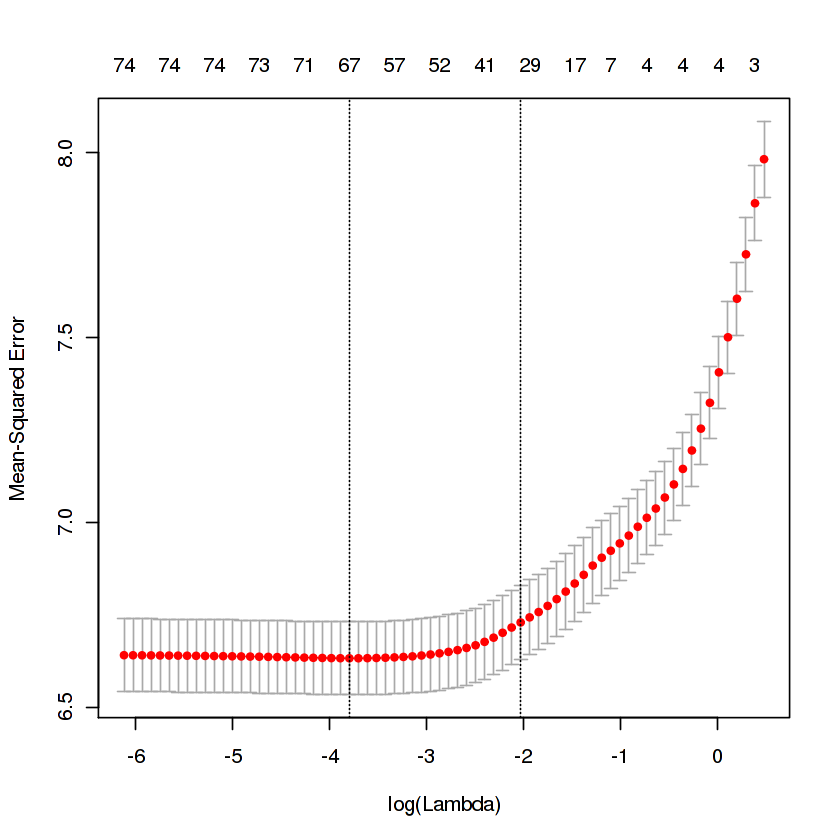

In [9]:
plot(ct.expr.models[["Body wall muscle"]])

In [20]:
get.model.R2 = function(model, min=F) {
    if (min)
        model$glmnet.fit$dev.ratio[which(model$lambda == model$lambda.min)]
    else
        model$glmnet.fit$dev.ratio[which(model$lambda == model$lambda.1se)]
}

In [21]:
summary(sapply(ct.expr.models, get.model.R2), decreasing = T)
sort(sapply(ct.expr.models, get.model.R2), decreasing = T)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04268 0.07667 0.08997 0.09654 0.11950 0.16210 

Body wall muscle                Intestine                 Germline 
              0.16214791               0.16154686               0.14138645 
     Cholinergic neurons      Non-seam hypodermis Ciliated sensory neurons 
              0.13076013               0.12677875               0.12246750 
                  Rectum Intestinal/rectal muscle               Seam cells 
              0.12044089               0.11856590               0.11574199 
       GABAergic neurons        Pharyngeal muscle            Sex myoblasts 
              0.10706491               0.09810541               0.09365196 
      Other interneurons Somatic gonad precursors        Vulval precursors 
              0.09036856               0.08996576               0.08992870 
  Oxygen sensory neurons     Pharyngeal epithelia             Socket cells 
              0.08742869               0.08649470               0.08344525 
      Pharyngeal neurons         Distal tip cells    flp-1(+) interneurons 
              0.08205380               0.07901364               0.07433532 
         Excretory cells   Touch receptor neurons             Coelomocytes 
              0.07243506               0.07029228               0.06512619 
        Pharyngeal gland       Am/PH sheath cells Canal associated neurons 
              0.04936270               0.04499635               0.04268169

In [12]:
model.coef.df = do.call(rbind, lapply(cell.types, function(ct) { data.frame(
    cell.type = ct,
    tf = names(coef(ct.expr.models[[ct]], s = "lambda.1se")[-1, 1]),
    value = coef(ct.expr.models[[ct]], s = "lambda.1se")[-1, 1]) }))

model.coef.mat = acast(model.coef.df, tf ~ cell.type, value.var = "value", fill = -999)
dim(model.coef.mat)

model.coef.mat = model.coef.mat[apply(model.coef.mat, 1, max) >= 5,]
dim(model.coef.mat)

model.coef.mat[1:5, 1:5]

[1] 139  27

[1] 49 27

,Germline,Intestinal/rectal muscle,Coelomocytes,Ciliated sensory neurons,Seam cells
ALY.2_PE,3.8008579,3.328370,-999.000000,-999.0000000,4.307476
C04F5.9_PE,6.5710888,-999.000000,0.000000,-999.0000000,0.000000
C16A3.4_PE,8.6008206,1.924676,1.798041,0.6503063,2.282488
F23B12.7_PE,5.6597240,0.000000,0.000000,-999.0000000,0.000000
F37D6.2_PE,-0.9263371,0.000000,0.000000,0.0000000,0.000000


In [13]:
zork = model.coef.mat
zork = ifelse(zork < 0 & zork != -999, 0, zork)
zork = ifelse(zork == -999, -0.1, zork)
zork = ifelse(zork > 10, 10, zork)

pal = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(250)
pal[1] = "grey60"
pal = pal[c(1, 71:250)]

In [14]:
rownames(zork) = sub("(?<=[A-Z])[.]", "-", rownames(zork), perl = T)
rownames(zork) = sub("_", " ", rownames(zork))
rownames(zork) = sub("EM", "(EM)", rownames(zork))
rownames(zork) = sub("PE", "(PE)", rownames(zork))
rownames(zork)

[1] "ALY-2 (PE)"    "C04F5.9 (PE)"  "C16A3.4 (PE)"  "F23B12.7 (PE)"
 [5] "F37D6.2 (PE)"  "F49E8.2 (PE)"  "LIN-13 (PE)"   "LIN-53 (PE)"  
 [9] "LIN-9 (PE)"    "MES-2 (PE)"    "R02D3.7 (PE)"  "RBR-2 (PE)"   
[13] "XBP-1 (PE)"    "XND-1 (PE)"    "ZTF-4 (PE)"    "ZTF-7 (PE)"   
[17] "CEH-18 (EM)"   "EGL-13 (PE)"   "F13C5.2 (EM)"  "F16B12.6 (PE)"
[21] "HLH-8 (EM)"    "HMG-11 (PE)"   "LIN-15B (PE)"  "MAB-5 (PE)"   
[25] "SYD-9 (EM)"    "UNC-120 (EM)"  "ZAG-1 (PE)"    "CEH-34 (EM)"  
[29] "CEH-39 (EM)"   "LIN-39 (PE)"   "NHR-21 (PE)"   "CEH-48 (EM)"  
[33] "ELT-2 (PE)"    "FKH-10 (PE)"   "FKH-8 (PE)"    "UNC-42 (EM)"  
[37] "UNC-86 (PE)"   "ZTF-11 (PE)"   "BLMP-1 (PE)"   "CEH-16 (PE)"  
[41] "ETS-4 (EM)"    "NHR-25 (PE)"   "NHR-43 (PE)"   "RNT-1 (PE)"   
[45] "PHA-4 (PE)"    "HLH-1 (EM)"    "CEH-31 (EM)"   "UNC-55 (PE)"  
[49] "CES-1 (PE)"

In [15]:
rownames(zork) = ifelse(rownames(zork) == "F37D6.2 (PE)", "ROW-1 (PE)", rownames(zork))

In [16]:
pdf("plots/Fig_5.pdf", width = 4, height = 6, onefile = F)
pheatmap(zork, scale = "none", clustering_method = "ward.D2",
    treeheight_row = 16, treeheight_col = 16, fontsize = 6, color = pal)
dev.off()

PNG 
  2

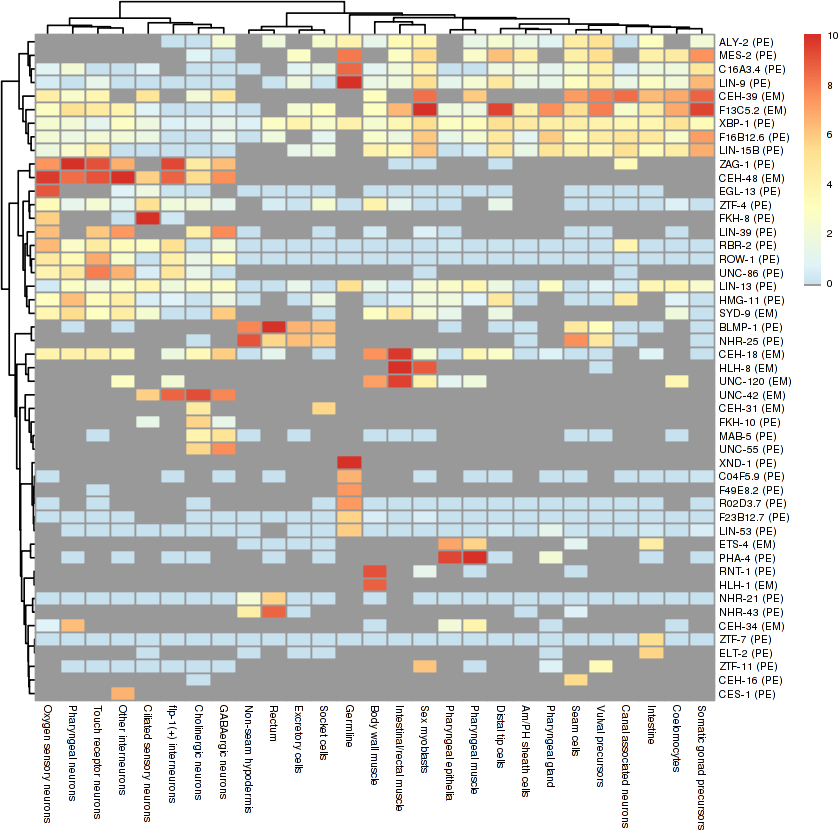

In [17]:
pheatmap(zork, scale = "none", clustering_method = "ward.D2",
    treeheight_row = 16, treeheight_col = 16, fontsize = 6, color = pal)

In [22]:
genes.with.peak = list()
genes.without.peak = list()

for (TF in all.TFs) {
    if (sum(df[df$gene %in% all.heatmap.genes, TF]) > 0) {
        genes.with.peak[[TF]] = df[df$gene %in% all.heatmap.genes & df[, TF] > 0,]$gene
        genes.without.peak[[TF]] = df[df$gene %in% all.heatmap.genes & df[, TF] == 0,]$gene
    }
}

In [23]:
for (TF in c("Germline:EFL.1_PE", "Germline:DPL.1_PE")) {
    if (sum(df[df$gene %in% all.heatmap.genes, TF]) > 0) {
        genes.with.peak[[TF]] = df[df$gene %in% all.heatmap.genes & df[, TF] > 0,]$gene
        genes.without.peak[[TF]] = df[df$gene %in% all.heatmap.genes & df[, TF] == 0,]$gene
    }
}

In [24]:
genes.highest.expressed.in = list()

for (ct in cell.types) {
    genes.highest.expressed.in[[ct]] =
        intersect(
            (top.2.cell.types.per.gene %>% filter(max.cell.type == ct))$gene,
            all.heatmap.genes)
}

In [25]:
length(genes.with.peak[["FKH.8_PE"]])

[1] 606

In [26]:
zork = data.frame(
    TF = c("HLH.1_EM", "HLH.8_EM",
           "PHA.4_PE", "PHA.4_PE",
           "FKH.8_PE", "UNC.86_PE", "UNC.55_PE",
           "NHR.25_PE", "NHR.25_PE",
           "ELT.2_PE", "ZTF.7_PE",
           "XND.1_PE", "F49E8.2_PE"),
    cell.type = c(
        "Body wall muscle", "Intestinal/rectal muscle",
        "Pharyngeal muscle", "Pharyngeal epithelia",
        "Ciliated sensory neurons", "Touch receptor neurons", "GABAergic neurons",
        "Non-seam hypodermis", "Socket cells",
        "Intestine", "Intestine",
        "Germline", "Germline"),
    label = c(
        "HLH-1 (EM)\nBody wall muscle",
        "HLH-8 (EM)\nIntestinal/rectal muscle",
        "PHA-4 (PE)\nPharyngeal muscle",
        "PHA-4 (PE)\nPharyngeal epithelia",
        "FKH-8 (PE)\nCiliated sensory neurons",
        "UNC-86 (PE)\nTouch receptor neurons",
        "UNC-55 (PE)\nGABAergic neurons",
        "NHR-25 (PE)\nNon-seam hypodermis",
        "NHR-25 (PE)\nSocket cells",
        "ELT-2 (PE)\nIntestine",
        "ZTF-7 (PE)\nIntestine",
        "XND-1 (PE)\nGermline",
        "F49E8.2 (PE)\nGermline"), stringsAsFactors = F)
    
zork$prop.with.peak = mapply(function(TF, ct) {
    length(intersect(genes.with.peak[[TF]], genes.highest.expressed.in[[ct]])) / length(genes.with.peak[[TF]])
}, zork$TF, zork$cell.type)
    
zork$prop.without.peak = mapply(function(TF, ct) {
    length(intersect(genes.without.peak[[TF]], genes.highest.expressed.in[[ct]])) / length(genes.without.peak[[TF]])
}, zork$TF, zork$cell.type)
    
zork$ratio = zork$prop.with.peak / zork$prop.without.peak
    
zork

TF,cell.type,label,prop.with.peak,prop.without.peak,ratio
HLH.1_EM,Body wall muscle,HLH-1 (EM) Body wall muscle,0.16878981,0.01941140,8.695398
HLH.8_EM,Intestinal/rectal muscle,HLH-8 (EM) Intestinal/rectal muscle,0.13138686,0.01958471,6.708645
PHA.4_PE,Pharyngeal muscle,PHA-4 (PE) Pharyngeal muscle,0.07280514,0.01511370,4.817162
PHA.4_PE,Pharyngeal epithelia,PHA-4 (PE) Pharyngeal epithelia,0.10206995,0.02981143,3.423853
FKH.8_PE,Ciliated sensory neurons,FKH-8 (PE) Ciliated sensory neurons,0.31353135,0.04096416,7.653797
UNC.86_PE,Touch receptor neurons,UNC-86 (PE) Touch receptor neurons,0.12587413,0.02365798,5.320578
UNC.55_PE,GABAergic neurons,UNC-55 (PE) GABAergic neurons,0.10352673,0.03413499,3.032863
NHR.25_PE,Non-seam hypodermis,NHR-25 (PE) Non-seam hypodermis,0.12970711,0.01646403,7.878210
NHR.25_PE,Socket cells,NHR-25 (PE) Socket cells,0.08786611,0.03584093,2.451558
ELT.2_PE,Intestine,ELT-2 (PE) Intestine,0.34081104,0.04185672,8.142325


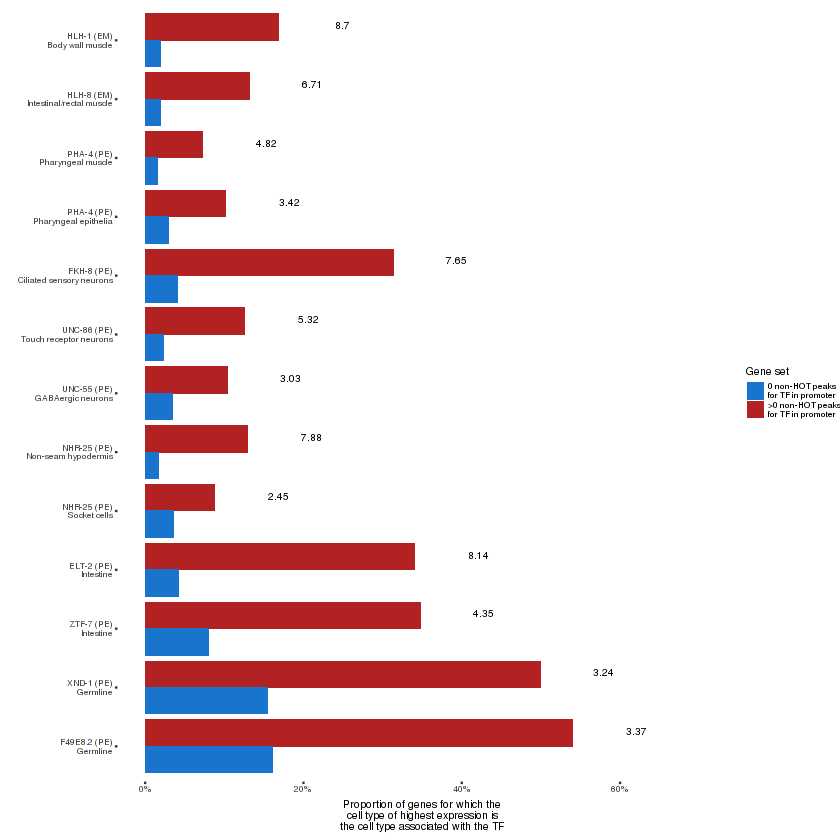

In [27]:
tmp.df = melt(zork, id.vars = c("TF", "cell.type", "label", "ratio"),
    variable.name = "variable", value.name = "value")

tmp.df$label = factor(tmp.df$label, levels = rev(unique(tmp.df$label)))
tmp.df$variable = ifelse(tmp.df$variable == "prop.with.peak",
    ">0 non-HOT peaks\nfor TF in promoter",
    "0 non-HOT peaks\nfor TF in promoter")
tmp.df$variable = factor(tmp.df$variable, levels = rev(unique(tmp.df$variable)))

plot = ggplot(tmp.df, aes(x = label, y = value, fill = variable)) +
    geom_bar(stat = "identity", position = "dodge") +
    geom_text(aes(y = value + 0.08, label = round(ratio, 2), group = variable, alpha = variable),
        position = position_dodge(1.0), size = 2.0) +
    coord_flip() +
    scale_y_continuous(limits = c(0, 0.7), breaks = seq(0, 0.8, 0.2), labels = percent) +
    scale_fill_manual(values = c("dodgerblue3", "firebrick")) +
    scale_alpha_manual(values = c(0, 1)) +
    xlab("") + ylab("Proportion of genes for which the\ncell type of highest expression is\nthe cell type associated with the TF") +
    guides(fill = guide_legend(title = "Gene set"), alpha = F) +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts() +
    theme(
        axis.title.x = element_text(margin = margin(5, 0, 0, 0)),
        legend.key.size = unit(0.4, "cm"),
        legend.margin = margin(0, 0, 0, 0))

show(plot)

ggsave("plots/Fig_S12.pdf",
    device = cairo_pdf, units = "in", width = 3.0, height = 4.5)

In [158]:
save.image("RData/L2.ChIP-seq.analysis.RData")

In [30]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/C.elegans.modENCODE.modERN.post-embryonic.ChIP.peak.clusters.melted.tsv",
    destfile = "RData/C.elegans.modENCODE.modERN.post-embryonic.ChIP.peak.clusters.melted.tsv")

In [31]:
PE.peak.clusters.melt = read.table(
    "RData/C.elegans.modENCODE.modERN.post-embryonic.ChIP.peak.info.melted.tsv",
    col.names = c("cluster.id", "gene", "distance.to.TSS", "distance.ratio", "TF"),
    colClasses = c("integer", "character", "integer", "numeric", "character"))

PE.peak.clusters.melt$dummy = 1
head(PE.peak.clusters.melt)

cluster.id,gene,distance.to.TSS,distance.ratio,TF,dummy
1,nlp-40,7604,5.24,ATF.7,1
1,nlp-40,7604,5.24,ATHP.1,1
1,nlp-40,7604,5.24,B0261.1,1
1,nlp-40,7604,5.24,C01B12.2,1
1,nlp-40,7604,5.24,C06A8.2,1
1,nlp-40,7604,5.24,C16A3.4,1


In [32]:
cluster.df = dcast(PE.peak.clusters.melt,
    cluster.id + gene + distance.to.TSS + distance.ratio ~ TF,
    value.var = "dummy", fun.aggregate = max, fill = 0)

cluster.df.TFs = intersect(PE.TFs, unique(do.call(c, cell.type.expr.TFs)))
cluster.df.TFs = intersect(sub("_PE", "", cluster.df.TFs), colnames(cluster.df))
cluster.df.TFs.incl.TS = sort(c(cluster.df.TFs, colnames(cluster.df)[grepl(":", colnames(cluster.df))]))

length(cluster.df.TFs)
length(cluster.df.TFs.incl.TS)

cluster.df$n.TFs = apply(cluster.df[, cluster.df.TFs], 1, function(x) sum(x))

nrow(cluster.df)
cluster.df = cluster.df[, c(
    "cluster.id", "gene", "n.TFs", "distance.to.TSS", "distance.ratio", cluster.df.TFs.incl.TS)] %>%
    filter(n.TFs < 0.1 * length(PE.TFs), distance.to.TSS < 2000, distance.ratio >= 1.5)

nrow(cluster.df)
head(cluster.df)

[1] 165

[1] 174

[1] 35564

[1] 11778

cluster.id,gene,n.TFs,distance.to.TSS,distance.ratio,ALR.1,ALY.2,ATF.7,ATHP.1,B0035.1,...,ZFP.2,ZIM.3,ZIP.2,ZK185.1,ZK546.5,ZTF.11,ZTF.18,ZTF.26,ZTF.4,ZTF.7
3,homt-1,1,494,1.561,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,nlp-40,8,152,7.322,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14,sesn-1,4,231,25.950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,sesn-1,3,1320,5.366,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,sesn-1,1,1726,4.339,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,Y74C9A.1,1,650,6.745,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
input.matrices.for.glasso = list()

In [122]:
mat = as.matrix(cluster.df[, cluster.df.TFs.incl.TS])
mat = mat[, apply(mat, 2, sum) >= 20]

input.matrices.for.glasso[["ChIP clusters"]] = mat
rm(mat)

In [123]:
valid.TFs = cluster.df.TFs.incl.TS
valid.TFs = valid.TFs[grepl(":", valid.TFs) |
                      paste(valid.TFs, "PE", sep="_") %in% tissue.expr.TFs[["Hypodermis"]]]
length(valid.TFs)

mat = as.matrix(cluster.df[cluster.df$gene %in% ts.gene.lists[["Hypodermis"]], valid.TFs])
mat = mat[, apply(mat, 2, sum) >= 20]

input.matrices.for.glasso[["ChIP clusters in hypodermis enriched gene promoters"]] = mat
rm(list = c("mat", "valid.TFs"))

[1] 122

In [124]:
valid.TFs = cluster.df.TFs.incl.TS
valid.TFs = valid.TFs[grepl(":", valid.TFs) |
                      paste(valid.TFs, "PE", sep="_") %in% tissue.expr.TFs[["Neurons"]]]
length(valid.TFs)

mat = as.matrix(cluster.df[cluster.df$gene %in% ts.gene.lists[["Neurons"]], valid.TFs])
mat = mat[, apply(mat, 2, sum) >= 20]

input.matrices.for.glasso[["ChIP clusters in neuron enriched gene promoters"]] = mat
rm(list = c("mat", "valid.TFs"))

[1] 125

In [125]:
valid.TFs = cluster.df.TFs.incl.TS
valid.TFs = valid.TFs[grepl(":", valid.TFs) |
                      paste(valid.TFs, "PE", sep="_") %in% cell.type.expr.TFs[["Intestine"]]]
length(valid.TFs)

mat = as.matrix(cluster.df[cluster.df$gene %in% cts.gene.lists[["Intestine"]], valid.TFs])
mat = mat[, apply(mat, 2, sum) >= 20]

input.matrices.for.glasso[["ChIP clusters in intestine enriched gene promoters"]] = mat
rm(list = c("mat", "valid.TFs"))

[1] 111

In [126]:
valid.TFs = cluster.df.TFs.incl.TS
valid.TFs = valid.TFs[grepl(":", valid.TFs) |
                      paste(valid.TFs, "PE", sep="_") %in% cell.type.expr.TFs[["Germline"]]]
length(valid.TFs)

mat = as.matrix(cluster.df[cluster.df$gene %in% cts.gene.lists[["Germline"]], valid.TFs])
mat = mat[, apply(mat, 2, sum) >= 20]

input.matrices.for.glasso[["ChIP clusters in germline enriched gene promoters"]] = mat
rm(list = c("mat", "valid.TFs"))

[1] 82

In [127]:
data.frame(
    nrow = sapply(input.matrices.for.glasso, nrow),
    ncol = sapply(input.matrices.for.glasso, ncol))

,nrow,ncol
ChIP clusters,11778,126
ChIP clusters in hypodermis enriched gene promoters,359,18
ChIP clusters in neuron enriched gene promoters,681,18
ChIP clusters in intestine enriched gene promoters,410,18
ChIP clusters in germline enriched gene promoters,208,15


In [128]:
# http://www.nature.com/articles/ncomms5114
curve.ball = function(m) {
    RC = dim(m)
    R = RC[1]
    C = RC[2]
    hp = list()
    for (row in 1:dim(m)[1]) {
        hp[[row]] = which(m[row,] == 1)
    }

    l_hp = length(hp)
    for (rep in 1:(5*l_hp)) {
        AB = sample(1:l_hp, 2)
        a = hp[[AB[1]]]
        b = hp[[AB[2]]]
        ab = intersect(a,b)
        l_ab = length(ab)
        l_a = length(a)
        l_b = length(b)
        if ((l_ab %in% c(l_a,l_b)) == F) {
            tot = setdiff(c(a,b), ab)
            l_tot = length(tot)
            tot = sample(tot, l_tot, replace = FALSE, prob = NULL)
            L = l_a - l_ab
            hp[[AB[1]]] = c(ab,tot[1:L])
            hp[[AB[2]]] = c(ab,tot[(L+1):l_tot])
        }
    }

    rm = matrix(0, R, C)
    for (row in 1:R) {
        rm[row, hp[[row]]] = 1
    }

    rownames(rm) = rownames(m)
    colnames(rm) = colnames(m)

    Matrix(rm, sparse=T)
}

In [133]:
shuffled.matrices.for.glasso = list()

for (i in 1:30) {
    message(i)
    shuffled.matrices.for.glasso[[i]] = list()
    
    for (name in names(input.matrices.for.glasso)) {
        shuffled.matrices.for.glasso[[i]][[name]] = curve.ball(input.matrices.for.glasso[[name]])
    }
}

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [305]:
save.image("RData/L2.ChIP-seq.analysis.RData")

In [331]:
glasso.res.to.network.df = function(glasso.res, v) {
    pcor = glasso.res$wi /
        (-sqrt(diag(glasso.res$wi) %*% t(diag(glasso.res$wi))))
    row.names(pcor) = row.names(v)
    colnames(pcor) = colnames(v)
    pcor.melt = melt(pcor)
    names(pcor.melt) = c("from", "to", "pcor")
    
    rv = solve(glasso.res$wi)
    row.names(rv) = row.names(v)
    colnames(rv) = colnames(v)
    rc = cov2cor(rv)
    rc.melt = melt(rc)
    names(rc.melt) = c("from", "to", "reg.cor")
    
    network.df = pcor.melt %>%
        inner_join(rc.melt, by=c("from", "to")) %>%
        filter(pcor > 0, reg.cor > 0) %>%
        mutate(weight = pcor) %>%
        arrange(-weight)
    
    return(network.df)
}

In [345]:
rho.list = c(seq(0.01, 0.2, 0.002))

nnz.edges.in.shuffled.matrices = list()
for (name in ls(input.matrices.for.glasso)) {
    nnz.edges.in.shuffled.matrices[[name]] = list()
    for (j in 1:length(rho.list)) {
        nnz.edges.in.shuffled.matrices[[name]][[j]] = integer()
    }
}

for (i in 1:30) {
    message(i)
    for (name in ls(input.matrices.for.glasso)) {
        v = cov(as.matrix(shuffled.matrices.for.glasso[[i]][[name]]))
        glasso.res = list()

        for (j in 1:length(rho.list)) {
            if (j == 1) {
                glasso.res[[j]] = glasso(v, rho = rho.list[j])
            } else {
                glasso.res[[j]] = glasso(v, rho = rho.list[j], start = "warm",
                    w.init = glasso.res[[j-1]]$w, wi.init = glasso.res[[j-1]]$wi)
            }

            network.df = glasso.res.to.network.df(glasso.res[[j]], v)
            nnz.edges.in.shuffled.matrices[[name]][[j]] = c(
                nnz.edges.in.shuffled.matrices[[name]][[j]], nrow(network.df))
        }
    }
}

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


ERROR: Error in as.matrix(shuffled.matrices.for.glasso[[i]][[name]]): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': Error in shuffled.matrices.for.glasso[[i]] : subscript out of bounds



In [349]:
glasso.res = list()
for (name in ls(input.matrices.for.glasso)) {
    glasso.res[[name]] = list()
}

for (name in ls(input.matrices.for.glasso)) {
    message(name)
    v = cov(as.matrix(input.matrices.for.glasso[[name]]))
    
    for (j in 1:length(rho.list)) {
        if (j == 1) {
            glasso.res[[name]][[j]] = glasso(v, rho = rho.list[j])
        } else {
            glasso.res[[name]][[j]] = glasso(v, rho = rho.list[j], start = "warm",
                w.init = glasso.res[[name]][[j-1]]$w, wi.init = glasso.res[[name]][[j-1]]$wi)
        }

        glasso.res[[name]][[j]]$network.df = glasso.res.to.network.df(glasso.res[[name]][[j]], v)
        glasso.res[[name]][[j]]$est.fdr =
            mean(nnz.edges.in.shuffled.matrices[[name]][[j]]) /
            nrow(glasso.res[[name]][[j]]$network.df)
    }
}

ChIP clusters
ChIP clusters in gonad enriched gene promoters
ChIP clusters in hypodermis enriched gene promoters
ChIP clusters in intestine enriched gene promoters
ChIP clusters in neuron enriched gene promoters
ChIP clusters in TS gene promoters


In [361]:
save.image("RData/L2.ChIP-seq.analysis.RData")

In [354]:
selected.rho.indices = lapply(glasso.res, function(x) {
    which(sapply(x, function(y) y$est.fdr) < 0.05)[1]
})
          
sapply(selected.rho.indices, function(x) rho.list[x])

ChIP clusters 
                                              0.022 
     ChIP clusters in gonad enriched gene promoters 
                                              0.066 
ChIP clusters in hypodermis enriched gene promoters 
                                              0.072 
 ChIP clusters in intestine enriched gene promoters 
                                              0.126 
    ChIP clusters in neuron enriched gene promoters 
                                              0.020 
                 ChIP clusters in TS gene promoters 
                                              0.026

In [355]:
glasso.networks = list()

for (name in ls(glasso.res)) {
    glasso.networks[[name]] = glasso.res[[name]][[selected.rho.indices[[name]]]]$network.df
    glasso.networks[[name]]$from = as.character(glasso.networks[[name]]$from)
    glasso.networks[[name]]$to = as.character(glasso.networks[[name]]$to)
}

In [356]:
sapply(glasso.networks, function(x) filter(x, pcor >= 0.02) %>% nrow())

ChIP clusters 
                                                 56 
     ChIP clusters in gonad enriched gene promoters 
                                                 40 
ChIP clusters in hypodermis enriched gene promoters 
                                                  4 
 ChIP clusters in intestine enriched gene promoters 
                                                 18 
    ChIP clusters in neuron enriched gene promoters 
                                                 22 
                 ChIP clusters in TS gene promoters 
                                                 64

In [357]:
make.network = function(network.df, pcor.thresh = 0.0) {
    df = network.df %>% filter(pcor > pcor.thresh)
    df2 = df
    df2$tmp = df2$from
    df2$from = df2$to
    df2$to = df2$tmp
    df2$tmp = NULL
    df = rbind(df, df2)
    df = df %>% group_by(from, to) %>% summarize(n = n(), weight = max(pcor)) %>% ungroup()

    g = graph.data.frame(df %>% filter(from < to) %>% arrange(-weight), directed=F)
    return(g)
}

In [358]:
glasso.igraph = list()

for (name in ls(glasso.networks)) {
    glasso.igraph[[name]] = make.network(glasso.networks[[name]], 0.01)
}

In [30]:
plot.network = function(g, file, seed = 42, width = 4.0, height = 4.0,
                        vertex.size = 28, vertex.color = "#D4DCFF", edge.width.scaling = 100.0,
                        label.cex = 0.7, small.label.cex = 0.6, small.label.vertices = NULL,
                        name.map = NULL, repulse.rad.exp = 3.0, fr.n.iter = 500) {

    V(g)$color = vertex.color
    V(g)$label.cex = label.cex
    E(g)$color = "black"
    
    if (!is.null(small.label.vertices)) {
        V(g)$label.cex = sapply(V(g)$name, function(name) {
            ifelse(name %in% small.label.vertices, small.label.cex, label.cex)
        })
    }
    
    tmp.vec = V(g)$name
    names(tmp.vec) = tmp.vec
    full.name.map = lapply(tmp.vec, function(x) x)
    if (!is.null(name.map)) {
        for (key in names(name.map))
            full.name.map[[key]] = name.map[[key]]
    }

    V(g)$name = sapply(V(g)$name, function(term) full.name.map[[term]])

    cairo_pdf(file, width = width, height = height)
    set.seed(seed)

    g.layout = qgraph.layout.fruchtermanreingold(
        get.edgelist(g, names=F), weights = E(g)$weight, vcount = vcount(g),
        repulse.rad = vcount(g)^repulse.rad.exp, niter = fr.n.iter)

    par(mar=c(0,0,0,0))
    plot(g,
        edge.width = edge.width.scaling * E(g)$weight,
        vertex.size = vertex.size,
        vertex.label.family = "sans",
        vertex.label.color = "black",
        edge.color = E(g)$color,
        layout = g.layout)
    dev.off()
}

In [48]:
name.map = list(
    "LIN.9" = "LIN-9",
    "LIN.54" = "LIN-54",
    "EFL.1" = "EFL-1",
    "XND.1" = "XND-1",
    "Germline:EFL.1" = "EFL-1\n(GS)",
    "NHR.20" = "NHR-20",
    "SNU.23" = "SNU-23",
    "NHR.25" = "NHR-25",
    "BLMP.1" = "BLMP-1",
    "NHR.23" = "NHR-23",
    "PHA.4" = "PHA-4",
    "DAF.16" = "DAF-16",
    "DVE.1" = "DVE-1",
    "NHR.80" = "NHR-80",
    "PQM.1" = "PQM-1",
    "NHR.28" = "NHR-28",
    "ELT.2" = "ELT-2",
    "FOS.1" = "FOS-1",
    "PQM.1" = "PQM-1",
    "NHR.28" = "NHR-28",
    "SMA.9" = "SMA-9",
    "NHR.71" = "NHR-71")

plot.network(glasso.igraph[["ChIP clusters"]],
    file = "plots/Fig_S13d.pdf", width = 3.0, height = 3.0,
    vertex.size = 32 * 3.0/2.5 * 0.8, edge.width.scaling = 60.0, name.map = name.map,
    label.cex = 0.55, small.label.vertices = c("T02C12.2"), small.label.cex = 0.5)

PNG 
  2

In [363]:
plot.network(glasso.igraph[["ChIP clusters in TS gene promoters"]],
    file = "plots/ChIP.peak.co-localization.glasso.ts.genes.pdf", width = 4.0, height = 4.0,
    vertex.size = 32, label.cex = 0.7, edge.width.scaling = 100.0)

PNG 
  2

In [364]:
plot.network(glasso.igraph[["ChIP clusters in hypodermis enriched gene promoters"]],
    file = "plots/ChIP.peak.co-localization.glasso.hypodermis.enriched.genes.pdf", width = 4.0, height = 4.0,
    vertex.size = 32, label.cex = 0.7, edge.width.scaling = 100.0)

PNG 
  2

In [44]:
name.map = list(
    "FKH.8" = "FKH-8",
    "NHR.47" = "NHR-47",
    "NHR.71" = "NHR-71",
    "SWSN.7" = "SWSN-7",
    "LSY.2" = "LSY-2",
    "ZFP.1" = "ZFP-1",
    "NFYA.1" = "NFYA-1",
    "LIN.39" = "LIN-39",
    "UNC.55" = "UNC-55")

plot.network(glasso.igraph[["ChIP clusters in neuron enriched gene promoters"]],
    file = "plots/Fig_S13c.pdf", width = 2.5, height = 2.5,
    vertex.size = 32 * 4.0/2.5 * 0.8, edge.width.scaling = 60.0, name.map = name.map,
    label.cex = 0.55, small.label.vertices = c("T02C12.2"), small.label.cex = 0.5)

PNG 
  2

In [366]:
plot.network(glasso.igraph[["ChIP clusters in intestine enriched gene promoters"]],
    file = "plots/ChIP.peak.co-localization.glasso.intestine.enriched.genes.pdf", width = 4.0, height = 4.0,
    vertex.size = 32, label.cex = 0.7, edge.width.scaling = 100.0)

PNG 
  2

In [40]:
name.map = list(
    "Germline:EFL.1" = "EFL-1\n(GS)",
    "Germline:DPL.1" = "DPL-1\n(GS)",
    "XND.1" = "XND-1",
    "LIN.37" = "LIN-37",
    "LIN.9" = "LIN-9",
    "LIN.54" = "LIN-54",
    "EFL.1" = "EFL-1",
    "DPL.1" = "DPL-1")

plot.network(glasso.igraph[["ChIP clusters in gonad enriched gene promoters"]],
    file = "plots/Fig_S13a.pdf", width = 2.5, height = 2.5,
    vertex.size = 32 * 4.0/2.5 * 0.8, edge.width.scaling = 60.0, name.map = name.map,
    label.cex = 0.55, small.label.vertices = c("T02C12.2"), small.label.cex = 0.5)

PNG 
  2

In [92]:
zork = data.frame(
    tf.1 = c("F49E8.2_PE", "F49E8.2_PE", "F49E8.2_PE", "XND.1_PE", "XND.1_PE", "Germline:EFL.1_PE"),
    tf.2 = c("Germline:EFL.1_PE", "Germline:DPL.1_PE", "XND.1_PE",
             "Germline:EFL.1_PE", "Germline:DPL.1_PE", "Germline:DPL.1_PE"),
    label = c("dummy1", "dummy2", "dummy3", "dummy4", "dummy5", "dummy6"), stringsAsFactors = F)

zork$n.1 = sapply(zork$tf.1, function(x) {
    length(intersect(genes.with.peak[[x]], cts.gene.lists[["Germline"]]))
})

zork$n.2 = sapply(zork$tf.2, function(x) {
    length(intersect(genes.with.peak[[x]], cts.gene.lists[["Germline"]]))
})

zork$n.12 = mapply(function(x, y) {
   length(intersect(
       intersect(genes.with.peak[[x]], genes.with.peak[[y]]), cts.gene.lists[["Germline"]])) 
}, zork$tf.1, zork$tf.2)

zork$prop.1 = zork$n.1 / length(cts.gene.lists[["Germline"]])
zork$prop.2 = zork$n.2 / length(cts.gene.lists[["Germline"]])
zork$prop.12 = zork$n.12 / length(cts.gene.lists[["Germline"]])
zork$expected = zork$prop.1 * zork$prop.2
zork$ratio = zork$prop.12 / zork$expected

zork = zork %>% arrange(-prop.12)
zork$label = factor(zork$label, levels = zork$label)

zork

tf.1,tf.2,label,n.1,n.2,n.12,prop.1,prop.2,prop.12,expected,ratio
XND.1_PE,Germline:EFL.1_PE,dummy4,96,90,72,0.3127036,0.2931596,0.2345277,0.09167206,2.558333
Germline:EFL.1_PE,Germline:DPL.1_PE,dummy6,90,57,53,0.2931596,0.1856678,0.1726384,0.05443029,3.171735
F49E8.2_PE,XND.1_PE,dummy3,62,96,51,0.2019544,0.3127036,0.1661238,0.06315186,2.630544
F49E8.2_PE,Germline:EFL.1_PE,dummy1,62,90,49,0.2019544,0.2931596,0.1596091,0.05920487,2.695878
XND.1_PE,Germline:DPL.1_PE,dummy5,96,57,49,0.3127036,0.1856678,0.1596091,0.05805897,2.749086
F49E8.2_PE,Germline:DPL.1_PE,dummy2,62,57,38,0.2019544,0.1856678,0.1237785,0.03749642,3.301075


In [140]:
length(intersect(cts.gene.lists[["Germline"]],
    intersect(genes.with.peak[["F49E8.2_PE"]], genes.with.peak[["Germline:EFL.1_PE"]])))

length(intersect(cts.gene.lists[["Germline"]],
    setdiff(genes.with.peak[["F49E8.2_PE"]], genes.with.peak[["Germline:EFL.1_PE"]])))

length(intersect(cts.gene.lists[["Germline"]],
    setdiff(genes.with.peak[["Germline:EFL.1_PE"]], genes.with.peak[["F49E8.2_PE"]])))

length(setdiff(cts.gene.lists[["Germline"]],
    union(genes.with.peak[["F49E8.2_PE"]], genes.with.peak[["Germline:EFL.1_PE"]])))

[1] 49

[1] 13

[1] 41

[1] 204

In [144]:
chisq.test(cbind(c(49, 13), c(41, 204)))


	Pearson's Chi-squared test with Yates' continuity correction

data:  cbind(c(49, 13), c(41, 204))
X-squared = 89.687, df = 1, p-value < 2.2e-16


In [145]:
chisq.test(cbind(c(49, 13), c(41, 204)))$p.value

[1] 2.789364e-21

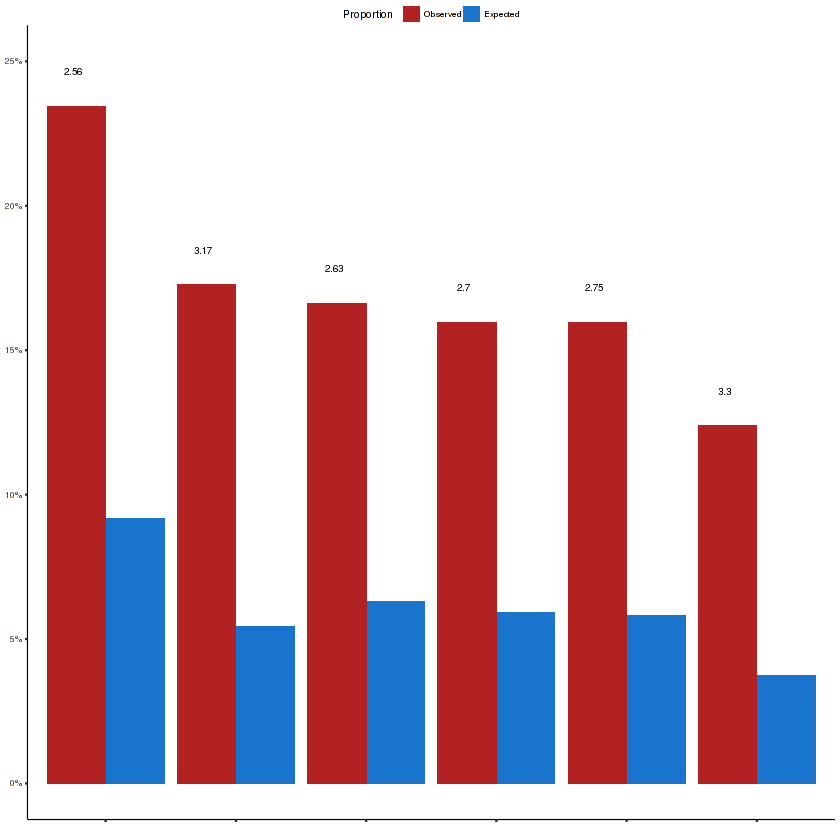

In [128]:
tmp.df = melt(zork[, c("label", "ratio", "prop.12", "expected")],
    id.vars = c("label", "ratio"), variable.name = "variable", value.name = "value")

tmp.df$variable = ifelse(tmp.df$variable == "prop.12", "Observed", "Expected")
tmp.df$variable = factor(tmp.df$variable, levels = c("Observed", "Expected"))

plot = ggplot(tmp.df, aes(x = label, y = value, fill = variable)) +
    geom_bar(stat = "identity", position = "dodge") +
    geom_text(aes(
        label = round(ratio, 2), y = value + 0.012,
        group = variable, alpha = variable), position = position_dodge(1.0), size = 1.9) +
    scale_y_continuous(limits = c(0, 0.25), breaks = seq(0, 1, 0.05), labels = percent) +
    scale_fill_manual(values = c("firebrick", "dodgerblue3")) +
    scale_alpha_manual(values = c(1, 0)) +
    xlab("") + ylab("Proportion of\ngermline enriched\ngene promoters") +
    guides(fill = guide_legend(title = "Proportion"), alpha = F) +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts() +
    theme(
        axis.line = element_line(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        legend.position = "top",
        legend.key.width = unit(0.15, "in"),
        legend.key.height = unit(0.15, "in"),
        legend.margin = margin(0, 0, -10, 0))

show(plot)

ggsave("plots/Fig_S13b.pdf", plot = plot,
    device = cairo_pdf, units = "in", width = 3.0, height = 2.0)

In [146]:
save.image("RData/L2.ChIP-seq.analysis.RData")